In [1]:
import os
os.environ["PATH"] += os.pathsep + '/home/zhangchen/latex/bin/x86_64-linux'
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [2]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

# Lion

In [3]:
import torch
import numpy as np

In [4]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
data_path = os.path.join(script_path,'data','demo','lion.png')
save_path = os.path.join(script_path,'out','Real-world')

RGB


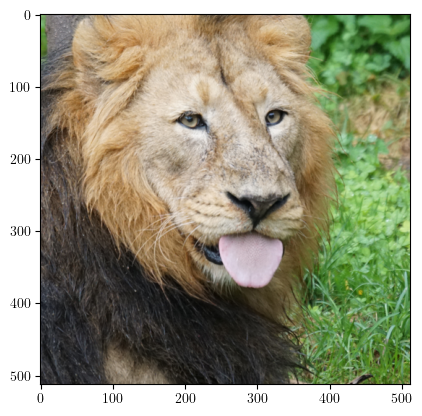

In [7]:
from PIL import Image
img = Image.open(data_path)
print(img.mode)
plt.imshow(img)

### scale lion

RGB


/tmp/ipykernel_117152/2239330588.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((min_side,min_side), Image.ANTIALIAS)  # resizes image in-place


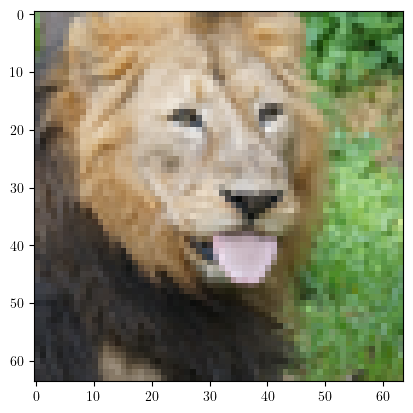

In [8]:
min_side = 64

from PIL import Image
img = Image.open(data_path)
img.thumbnail((min_side,min_side), Image.ANTIALIAS)  # resizes image in-place
print(img.mode)
plt.imshow(img)

#### RGB split

In [9]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

lion = transform(img)
print(torch.min(lion), torch.max(lion))

tensor(0.0275) tensor(0.9412)


In [10]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

In [11]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

lion = transform(img)
print(torch.min(lion), torch.max(lion))

tensor(0.0275) tensor(0.9412)


In [12]:
C, H, W = lion.shape
R_lion, G_lion, B_lion = RGB_split(lion)

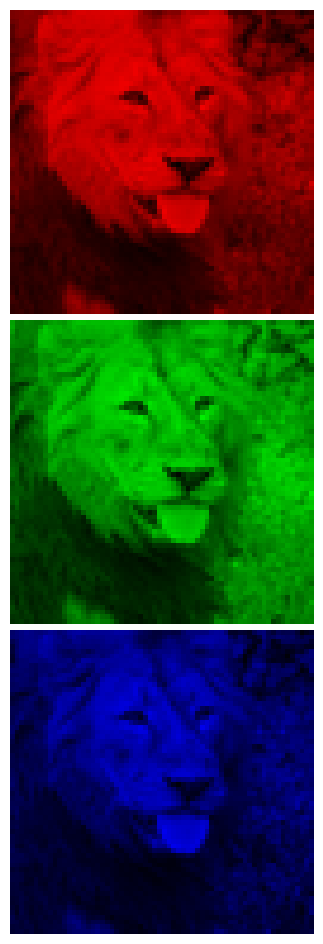

In [13]:
fig = plt.figure(figsize=(4,12))

ax = fig.add_subplot(3, 1, 1)
ax.imshow(R_lion)
ax.set_axis_off()
#plt.title('Red Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 2)
ax.imshow(G_lion)
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 3)
ax.imshow(B_lion)
ax.set_axis_off()
#plt.title('Blue Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

fig.subplots_adjust(hspace=0.02)
plt.show()

#fig.savefig(save_path+'/Lenna RGB.pdf'.format(1,2),bbox_inches='tight')
#fig.savefig(save_path+'/Lenna RGB.jpg'.format(1,2),bbox_inches='tight')

### Generate initial lion

In [14]:
import time
eta = 0.01  # Learning rate.
num_iterations = 20000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

/home/zhangchen/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)


In [17]:
Ainv = torch.tensor([[-.17,.21,.29],[.19,-.33,.24],[.22,.13,-.25]])
Ainv

tensor([[-0.1700,  0.2100,  0.2900],
        [ 0.1900, -0.3300,  0.2400],
        [ 0.2200,  0.1300, -0.2500]])

In [18]:
True_A = torch.linalg.inv(Ainv)
True_A

tensor([[ 1.2648,  2.2239,  3.6022],
        [ 2.4729, -0.5252,  2.3645],
        [ 2.3990,  1.6840,  0.3994]])

In [19]:
class preAdvancedM(torch.nn.Module):
    def __init__(self, A, input_dim, output_dim):
        super(preAdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        with torch.no_grad():
            self.linear.weight.copy_(A)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [20]:
transform = preAdvancedM(Ainv, C, C)
ini_lion = transform(lion.flatten(1).T).T.reshape(C, H, W).detach()

In [21]:
print(torch.min(ini_lion), torch.max(ini_lion))

tensor(-0.0875) tensor(0.3033)


In [22]:
R_lion, G_lion, B_lion = RGB_split(ini_lion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


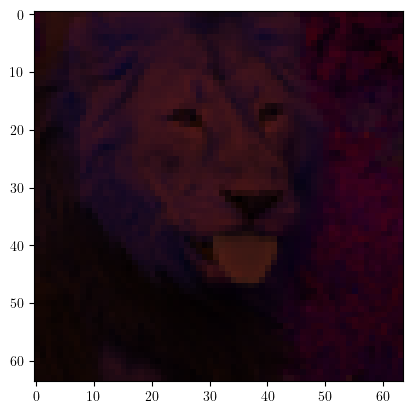

In [23]:
plt_ini_lion = torch.zeros([H, W, C])
plt_ini_lion[:,:,0], plt_ini_lion[:,:,1], plt_ini_lion[:,:,2] = R_lion[:,:,0], G_lion[:,:,1], B_lion[:,:,2]
plt.imshow(plt_ini_lion)
ax.set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


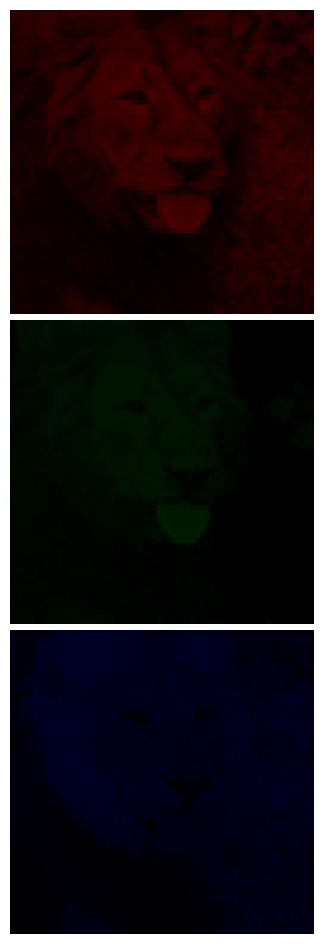

In [24]:
fig = plt.figure(figsize=(4,12))

ax = fig.add_subplot(3, 1, 1)
ax.imshow(R_lion)
ax.set_axis_off()
#plt.title('Red Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 2)
ax.imshow(G_lion)
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 3)
ax.imshow(B_lion)
ax.set_axis_off()
#plt.title('Blue Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

fig.subplots_adjust(hspace=0.02)
plt.show()

#fig.savefig(save_path+'/Lenna RGB.pdf'.format(1,2),bbox_inches='tight')
#fig.savefig(save_path+'/Lenna RGB.jpg'.format(1,2),bbox_inches='tight')

## Single

For loop over channel  
and loss is computed based on the 3 channel one

In [25]:
import time
eta = 0.01  # Learning rate.
num_iterations = 30000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [26]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [27]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [28]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

step = 0.05*num_iterations
for channel in range(C):
    iter_count = 0
    while iter_count < num_iterations:
        '''
        if np.remainder(iter_count, step) == 0:
            sel_idx = greedy_B(f_t[-1], y_star, 1)

        for random selection, generate sel_idx by random, random seed can be set as iter_count
        '''

        sel_idx = greedy_1(f_t[-1][channel].cuda(), y_star[channel])#, pool=True, plScale= 0.8
        '''
        np.random.seed(iter_count)
        sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
        '''

        '''
        example: [[x1,x2],[x1,x2]] int pixel point
        '''

        example = pixels[sel_idx]#torch.tensor([14,14])

        '''
        intorduce replacement
        '''
        label = y_star[channel][sel_idx] #f_star(example,channel)
        f_x = f_t[-1][channel][sel_idx]

        '''
        Need to clone otherwise previsous data will be changed as well
        '''
        temp = f_t[-1].detach().clone()
        temp[channel] = f_t[-1][channel].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
        
        f_t.append(temp.cpu())
        
        l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
        loss_t.append(l_t.item()) #norm over the cube
        tm_t.append(time.time() - training_start_time)
        iter_count += 1
        print('Channel: ',channel+1,' ',iter_count,'-th loss: ',loss_t[-1])
        print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [ ]:
a_f_t = []

ilist = [0, 2000, 5000, 10000, 20000, 29999]

for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        a_f_t.append(f_t[i])

In [ ]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Single_90k.pt')

Load data

In [29]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Single_90k.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

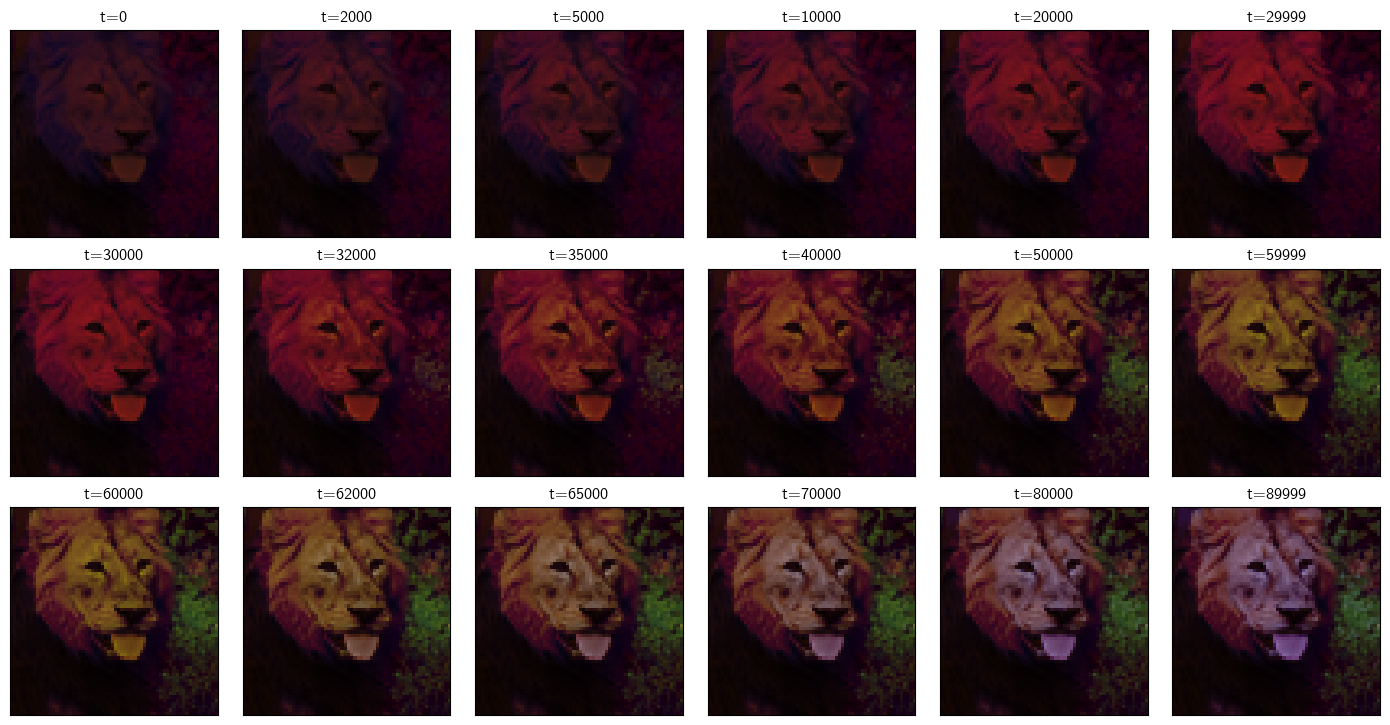

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.7, hspace = .15)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ilist = [0, 2000, 5000, 10000, 20000, 29999] #[0,50,150,250,350, 550]


for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        j = ite_list.index(i)
        mi = j + channel*6 #omit otherwise
        
        #Z = f_t[i].reshape(C, min_side,min_side) # alternative
        Z = a_f_t[mi].reshape(C, min_side,min_side)
        
        

        r_Z, g_Z, b_Z = Z.unbind(0)

        Z = torch.zeros([H, W, C])
        Z[:,:,0], Z[:,:,1], Z[:,:,2] = r_Z, g_Z, b_Z

        # Plot the surface.
        ax = fig.add_subplot(grid[channel,j])

        #surf = ax.contourf(X, -Y, Z, norm = norm, antialiased=False)

        ax.imshow(Z,norm = norm)
        
        # Customize the z axis.
        #ax.set_zlim(-1.01, 1.01)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        #ax.zaxis.set_major_formatter('{x:.02f}')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_zticks([])
        # Add a color bar which maps values to colors.

        #ax.view_init(90,0)

        plt.title('t={}'.format(i))
    #fig.colorbar(surf, shrink=0.22, aspect=5)

plt.show()
fig.savefig(save_path+'/Single_90k.pdf'.format(1,2),bbox_inches='tight')

show less

In [31]:
less_a_f_t = []
for i in [0,1,3,4,10,17]:
    less_a_f_t.append(a_f_t[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


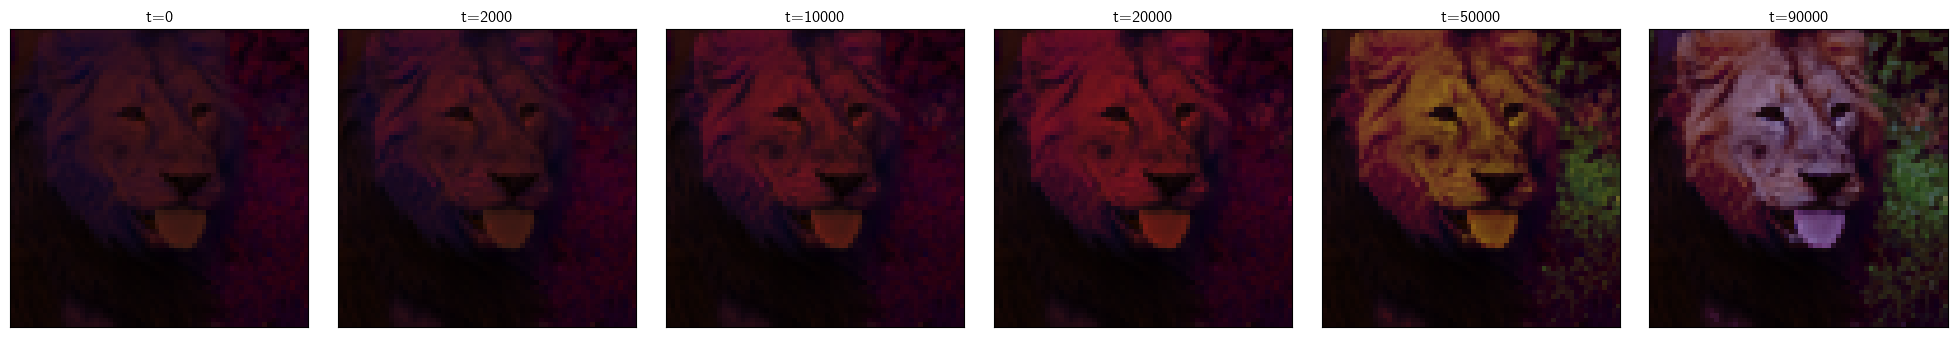

In [32]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0, 5000, 10000, 50000, 100000, 150000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = less_a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Single_90k_less.pdf'.format(1,2),bbox_inches='tight')

In [33]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in less_a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

7.576168279759834
7.645130789998426
7.881828598704222
8.146998318770995
8.881004247117092
10.068955969963374


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


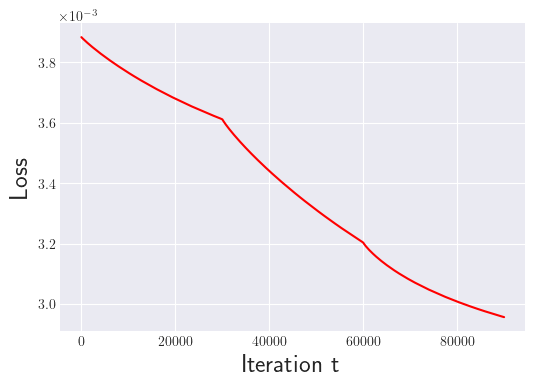

In [34]:
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
plt.plot(loss_t,color='red',linestyle='-')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.legend()
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## Vanilla

In [35]:
import time
eta = 0.01  # Learning rate.
num_iterations = 90000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [36]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [38]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [39]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    print(torch.sum(gradient[0]-gradient[1]))
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    '''
    Do not mean!!!!
    '''
    #gradient = torch.mean(gradient,axis=0)
    #print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    sel_idx = greedy_1(f_t[-1].cuda(), y_star)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    
    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx] 
    
    '''
    intorduce replacement
    '''
    
    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]],y_star[2,sel_idx[2]]])
    
    f_x = torch.vstack([f_t[-1][0,sel_idx[0]],f_t[-1][1,sel_idx[1]],f_t[-1][2,sel_idx[2]]])
    

    '''
    pixels are universal
    '''
    f_tt = f_t[-1].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
    f_t.append(f_tt.cpu())
    
    l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [ ]:
a_f_t = []

ite_list =  [0, 2000, 10000, 20000, 50000, 90000]

for i in ite_list:
    a_f_t.append(f_t[i])

In [ ]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Vanilla_90k.pt')

Load data

In [40]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Vanilla_90k.pt')

In [41]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

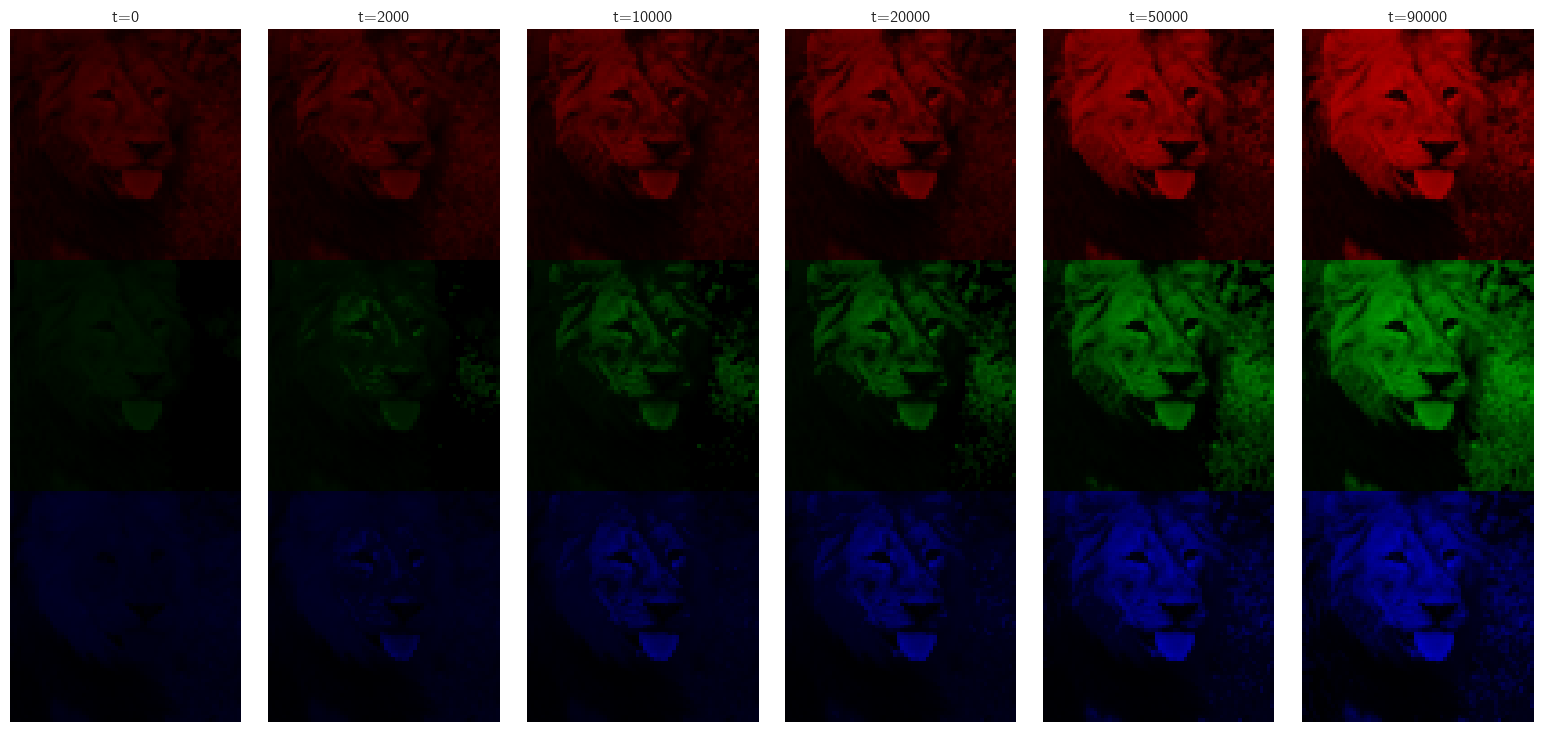

In [42]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.6, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    cmb_Z = [r_Z, g_Z, b_Z]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm)
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Vanilla RGB_90k.pdf'.format(1,2),bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


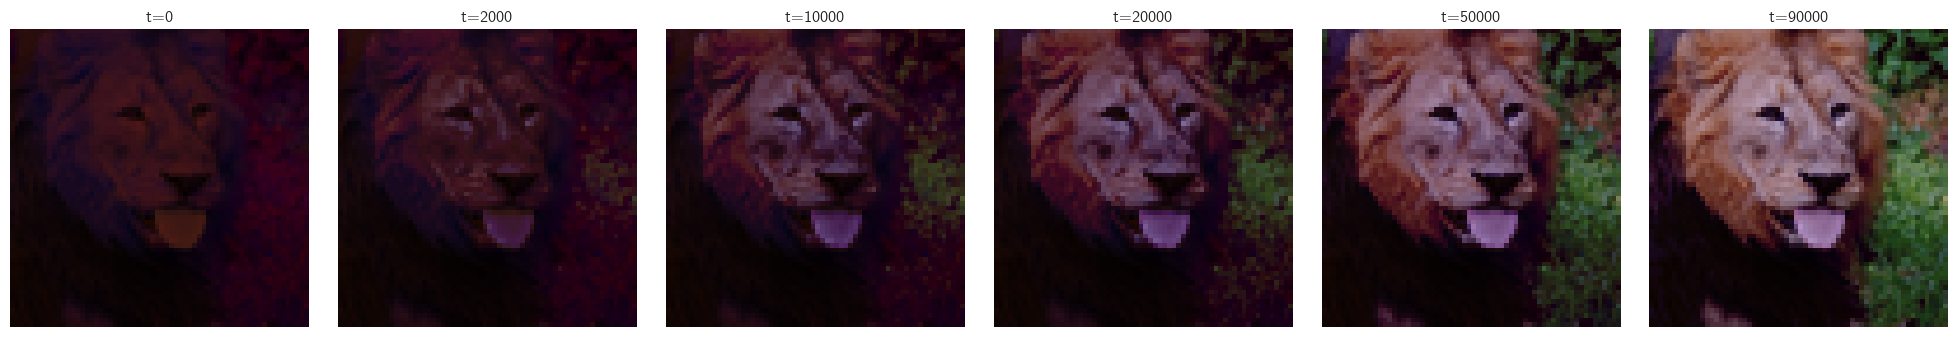

In [43]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0, 5000, 10000, 50000, 100000, 150000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Vanilla_90k.pdf'.format(1,2),bbox_inches='tight')

In [44]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

7.576168279759834
7.817717215449373
8.56482237548226
9.354688382405788
11.368091848903925
13.68015601306748


## Communicated

In [45]:
import time
eta = 0.01  # Learning rate.
num_iterations = 90000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

### each iteration

Train Advanced matrix A

In [46]:
y_0 = ini_lion.flatten(start_dim=1).cuda()
y_star = lion.flatten(start_dim=1).cuda()
f_0_T = y_0.T
f_s_T = y_star.T

In [47]:
class AdvancedM(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        torch.nn.init.eye_(self.linear.weight)

    def forward(self, x):
        nor = self.linear.weight.sum(dim=1)
        outputs = self.linear(x)/nor
        return outputs

In [48]:
def A_t(f_t, f_star, N=5000, epsi=0.0001, eta = 0.0001):
    '''
    f_t_T_unnor = f_t.T
    f_s_T_unnor = f_star.T
    
    f_t_T = torch.nn.functional.normalize(f_t_T_unnor,p=2.0, dim=1)
    f_s_T = torch.nn.functional.normalize(f_s_T_unnor,p=2.0, dim=1)
    '''
    
    f_t_T = f_t.T
    f_s_T = f_star.T
    
    MatrixA = AdvancedM(len(f_t), len(f_star)).cuda()
    optimizer = torch.optim.SGD(MatrixA.parameters(), lr=eta)
    
    loss_t = []

    loss_t.append(torch.norm(MatrixA(f_t_T)-f_s_T))

    iter_count = 0
    while iter_count < N and loss_t[-1] > epsi:
        iter_count += 1
        
        roll = MatrixA

        loss = torch.norm(MatrixA(f_t_T)-f_s_T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if torch.norm(MatrixA(f_t_T)-f_s_T).item() > loss_t[-1]:
            MatrixA = roll #rolling
            break    
        
        loss_t.append(loss.item())
        #print(iter_count,'-th test loss:', loss_t[-1])
        
    A = MatrixA.state_dict()['linear.weight']
    A = A/(A.sum(dim=1))[:, None]
    print('A norm for each is:', A.norm(dim=1))

    return MatrixA, A


In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []

y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())

y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''

    '''
    Advanced, commnication
    '''
    if iter_count<100:
        MatrixA_t, A = A_t(f_t[-1].cuda(), y_star)
        A_f_t=MatrixA_t(f_t[-1].T.cuda()).detach().T.cpu()
    else:
        A_f_t = f_t[-1]

    sel_idx = greedy_1(A_f_t.cuda(), y_star)#, pool=True, plScale= 0.8
    print(A)
    #print(sel_idx)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''

    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx]


    '''
    intorduce replacement
    '''

    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]],y_star[2,sel_idx[2]]])
    
    f_x = torch.vstack([A_f_t[0,sel_idx[0]],A_f_t[1,sel_idx[1]],A_f_t[2,sel_idx[2]]])
    

    '''
    pixels are universal
    '''
    f_tt = A_f_t.cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
    f_t.append(f_tt.cpu())

    l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [ ]:
a_f_t = []

ite_list =  [0, 2000, 10000, 20000, 50000, 90000]

for i in ite_list:
    a_f_t.append(f_t[i])

In [ ]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Advanced_each_ite_90k.pt')

Load data

In [49]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Advanced_each_ite_90k.pt')

In [50]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


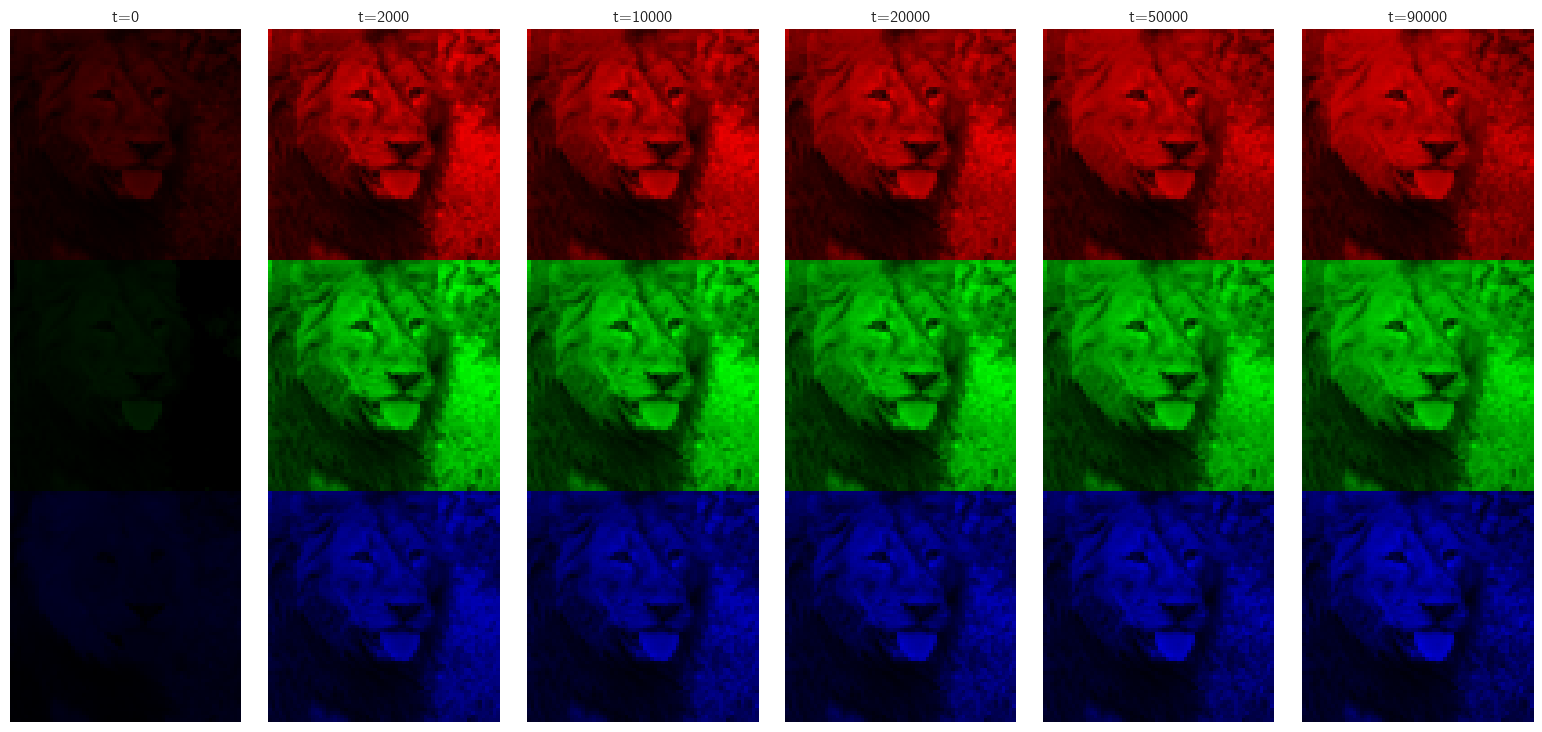

In [51]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.6, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    cmb_Z = [r_Z, g_Z, b_Z]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm)
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Advanced RGB_each_ite_90k.pdf'.format(1,2),bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


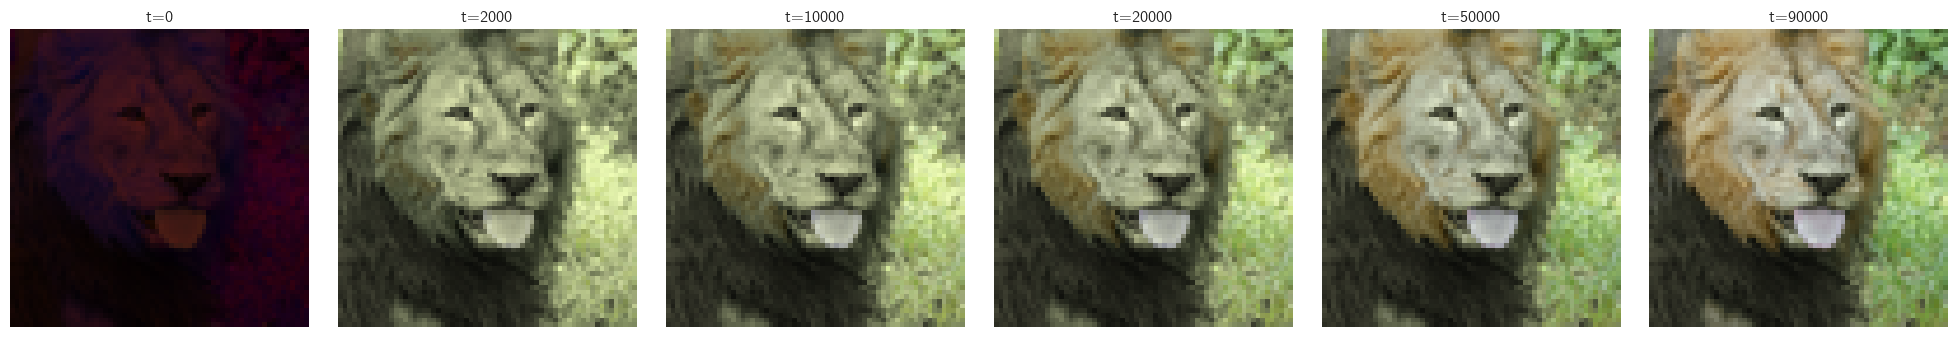

In [52]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Advanced_each_ite_90k.pdf'.format(1,2),bbox_inches='tight')

In [53]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

7.576168279759834
16.28524897711867
17.118412811548627
17.979238078980444
20.18875839333925
22.75204914381493


### One step

In [54]:
y_0 = ini_lion.flatten(start_dim=1).cuda()
y_star = lion.flatten(start_dim=1).cuda()
f_0_T = y_0.T
f_s_T = y_star.T

In [55]:
class AdvancedM(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        torch.nn.init.eye_(self.linear.weight)

    def forward(self, x):
        nor = self.linear.weight.sum(dim=1)
        outputs = self.linear(x)
        return outputs

In [56]:
def A_t(f_t, f_star, N=50000, epsi=0.0001, eta = 0.0001):
    '''
    f_t_T_unnor = f_t.T
    f_s_T_unnor = f_star.T
    
    f_t_T = torch.nn.functional.normalize(f_t_T_unnor,p=2.0, dim=1)
    f_s_T = torch.nn.functional.normalize(f_s_T_unnor,p=2.0, dim=1)
    '''
    
    f_t_T = f_t.T
    f_s_T = f_star.T
    
    MatrixA = AdvancedM(len(f_t), len(f_star)).cuda()
    optimizer = torch.optim.SGD(MatrixA.parameters(), lr=eta)
    
    loss_t = []

    loss_t.append(torch.norm(MatrixA(f_t_T)-f_s_T))

    iter_count = 0
    while iter_count < N and loss_t[-1] > epsi:
        iter_count += 1
        
        roll = MatrixA

        loss = torch.norm(MatrixA(f_t_T)-f_s_T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if torch.norm(MatrixA(f_t_T)-f_s_T).item() > loss_t[-1]:
            MatrixA = roll #rolling
            break    
        
        loss_t.append(loss.item())
        #print(iter_count,'-th test loss:', loss_t[-1])
        
    A = MatrixA.state_dict()['linear.weight']
#     A = A/(A.sum(dim=1))[:, None]
#     print('A norm for each is:', A.norm(dim=1))

    return MatrixA, A


In [57]:
MatrixA, A = A_t(y_0, y_star)

In [58]:
f_t = []
loss_t = []

f_t.append(y_0.cpu())
f_t.append(MatrixA(f_0_T).detach().T.cpu())

loss_t.append( (torch.norm(y_0-y_star)/(C*H*W)).cpu() )    
loss_t.append( (torch.norm(MatrixA(f_0_T).detach().T-y_star)/(C*H*W)).cpu() )

In [ ]:
Advancedloss_t = torch.zeros_like(torch.tensor(Vanillaloss_t))

In [ ]:
Advancedloss_t[0] = loss_t[0]
Advancedloss_t[1:-1] = loss_t[1]

In [ ]:
save_path = os.path.join(script_path,'out','Real-world')

In [ ]:
#torch.save([f_t, Advancedloss_t, A],save_path+'/Advanced.pt')

Load data

In [ ]:
save_path = os.path.join(script_path,'out','Real-world')

In [ ]:
#f_t, Advancedloss_t, A  = torch.load(save_path+'/Advanced.pt')

In [59]:
f_t[0].reshape(C, min_side,min_side).shape

torch.Size([3, 64, 64])

In [60]:
R_lion, G_lion, B_lion = RGB_split(f_t[0].reshape(C, min_side,min_side))
plt_ini_lion = torch.zeros([H, W, C])
plt_ini_lion[:,:,0], plt_ini_lion[:,:,1], plt_ini_lion[:,:,2] = R_lion[:,:,0], G_lion[:,:,1], B_lion[:,:,2]

In [61]:
R_f_0, G_f_0, B_f_0 = RGB_split(f_t[0].reshape(C, min_side,min_side))
plt_f_0 = torch.zeros([H, W, C])
plt_f_0[:,:,0], plt_f_0[:,:,1], plt_f_0[:,:,2] = R_f_0[:,:,0], G_f_0[:,:,1], B_f_0[:,:,2]

In [62]:
R_f_1, G_f_1, B_f_1 = RGB_split(f_t[1].reshape(C, min_side,min_side))
plt_f_1 = torch.zeros([H, W, C])
plt_f_1[:,:,0], plt_f_1[:,:,1], plt_f_1[:,:,2] = R_f_1[:,:,0], G_f_1[:,:,1], B_f_1[:,:,2]

In [63]:
torch.max(plt_f_1)

tensor(0.9412)

In [64]:
True_A[0,0]

tensor(1.2648)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


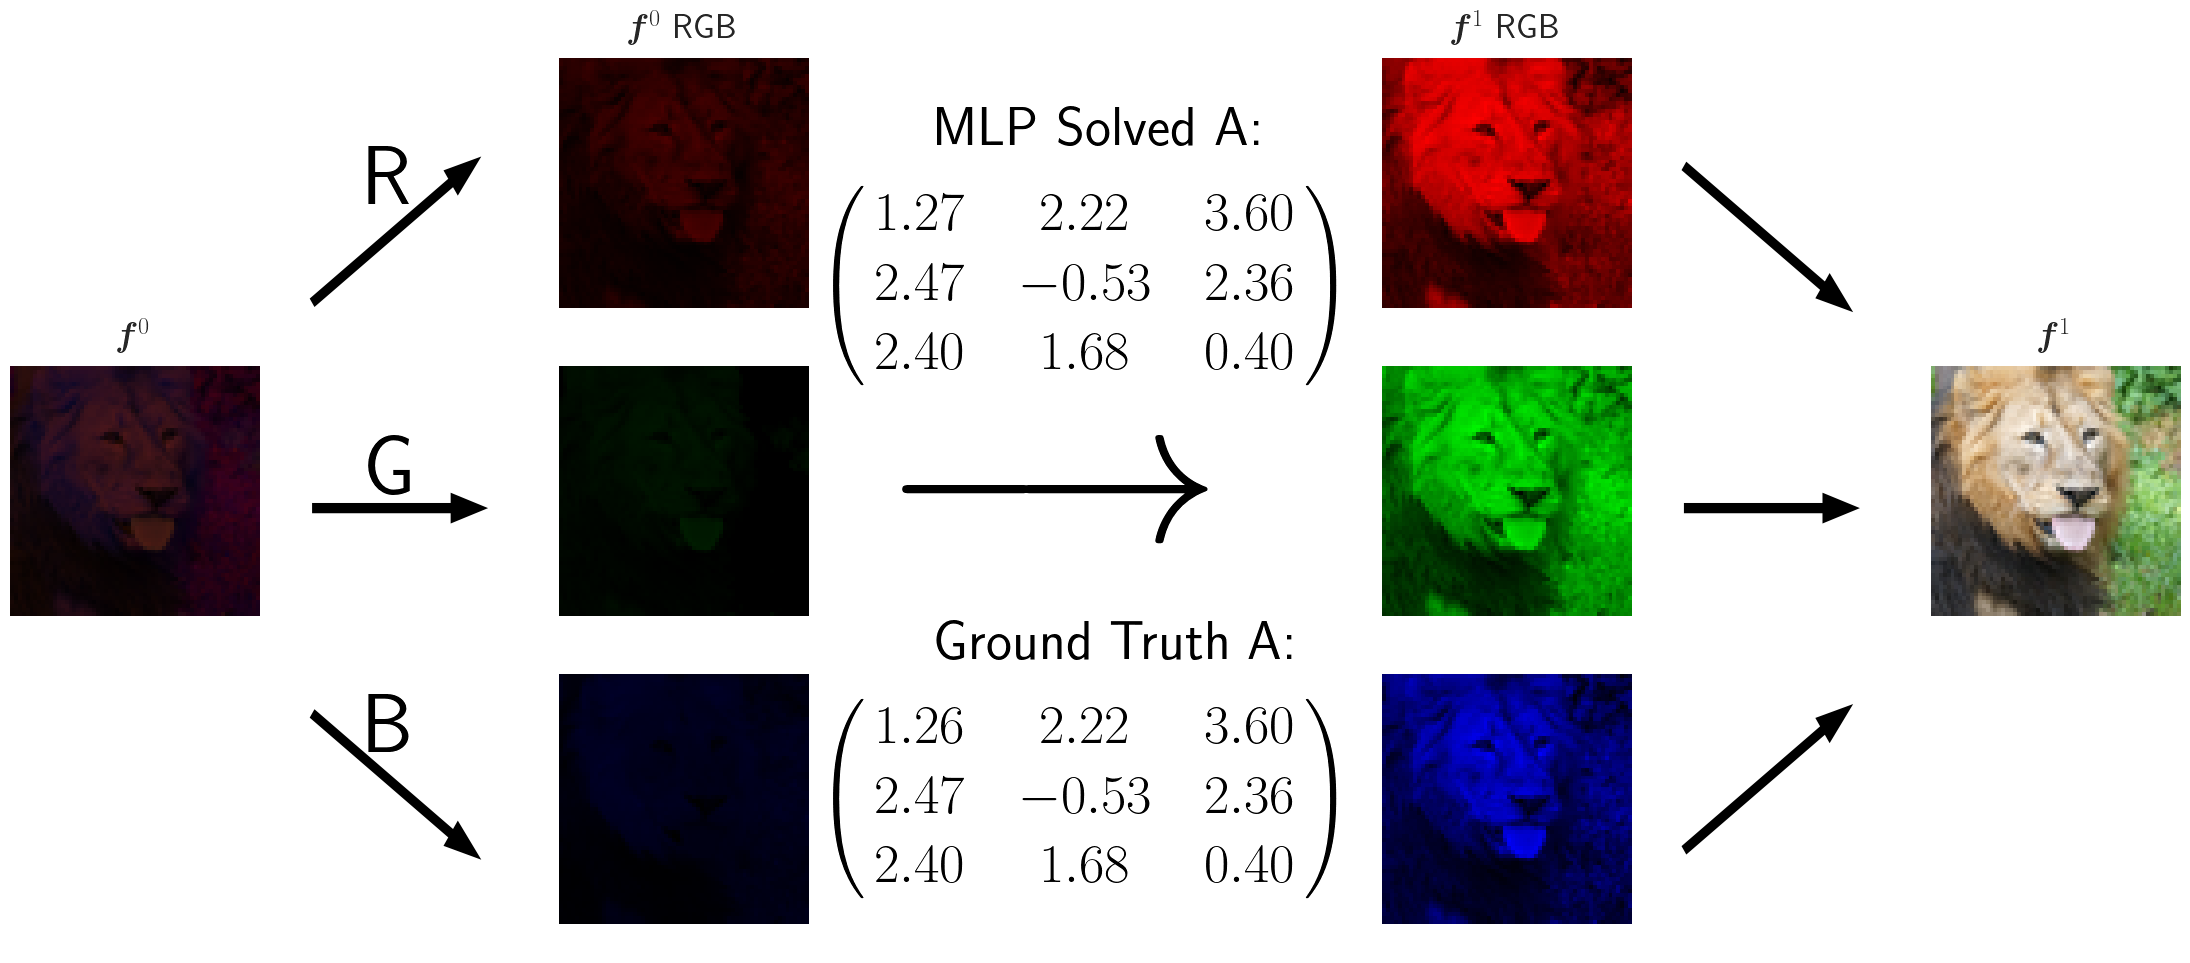

In [66]:
import matplotlib

rows = C
columns = 8

grid = plt.GridSpec(rows, columns, wspace = 0.1, hspace = .0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(28,12))


plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')


#------------------------------------------------f^0------------------------------------------------------
ax=fig.add_subplot(grid[1,0])
plt.imshow(plt_f_0)
ax.set_axis_off()
plt.title(r'$\bm{f}^0$',y=1.05,size = 25)

#-----------------------------------------------Arrow-------------------------------------------------------
ax=fig.add_subplot(grid[0,1])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.text(4,5.5,'R',
         fontdict={'size':60,'color':'black'},horizontalalignment='left',verticalalignment='center')
plt.arrow(x=2, y=2, dx=5, dy=3.5, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()

ax=fig.add_subplot(grid[1,1])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.text(4,6,'G',
         fontdict={'size':60,'color':'black'},horizontalalignment='left',verticalalignment='center')
plt.arrow(x=2, y=5, dx=5, dy=0, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()

ax=fig.add_subplot(grid[2,1])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.text(4,7.5,'B',
         fontdict={'size':60,'color':'black'},horizontalalignment='left',verticalalignment='center')
plt.arrow(x=2, y=8, dx=5, dy=-3.5, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()


#------------------------------------------------f^0 RGB--------------------------------------------------
ax = fig.add_subplot(grid[0,2])
ax.imshow(R_f_0)
ax.set_axis_off()
plt.title(r'$\bm{f}^0$'+' RGB',y=1.05,size = 25)

ax = fig.add_subplot(grid[1,2])
ax.imshow(G_f_0)
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(grid[2,2])
ax.imshow(B_f_0)
ax.set_axis_off()

#----------------------------------------------Matrix operation--------------------------------------------------------
ax=fig.add_subplot(grid[:,3:4])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
#plt.plot(pixels_2,y_0_2,color='springgreen',label=r'$f^0_2$', linewidth=3)
size = 40
plt.text(4.7,9,'MLP Solved A: ',
         fontdict={'size':size,'color':'black'},horizontalalignment='left',verticalalignment='center')
plt.text(1.0,7.5,r'$\left(\matrix{{{}}}\right)$'.
         format('{:.2f} & {:.2f} & {:.2f} \cr {:.2f} & {:.2f} & {:.2f} \cr {:.2f} & {:.2f} & {:.2f}'.
                format(A[0,0],A[0,1],A[0,2],A[1,0],A[1,1],A[1,2],A[2,0],A[2,1],A[2,2]) ),
         fontdict={'size':size,'color':'black'},horizontalalignment='left',verticalalignment='center')
#----arrow
plt.text(3.5,5.5,r'$\longrightarrow$',
         fontdict={'size':'150','color':'black'},horizontalalignment='left',verticalalignment='center')
#plt.arrow(x=2, y=5.5, dx=5, dy=0, facecolor='black', edgecolor='none', width=.1)
#----arrow

plt.text(4.7,4,'Ground Truth A: ',
         fontdict={'size':size,'color':'black'},horizontalalignment='left',verticalalignment='center')
plt.text(1.0,2.5,r'$\left(\matrix{{{}}}\right)$'.
         format('{:.2f} & {:.2f} & {:.2f} \cr {:.2f} & {:.2f} & {:.2f} \cr {:.2f} & {:.2f} & {:.2f}'.
                format(True_A[0,0],True_A[0,1],True_A[0,2],True_A[1,0],True_A[1,1],True_A[1,2],True_A[2,0],True_A[2,1],True_A[2,2]) ),
         fontdict={'size':size,'color':'black'},horizontalalignment='left',verticalalignment='center')
ax.set_axis_off()

#------------------------------------------------f^1 RGB--------------------------------------------------
ax = fig.add_subplot(grid[0,5])
ax.imshow(R_f_1/torch.max(plt_f_1))
ax.set_axis_off()
plt.title(r'$\bm{f}^1$'+' RGB',y=1.05,size = 25)
#plt.title('Red Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(grid[1,5])
ax.imshow(G_f_1/torch.max(plt_f_1))
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(grid[2,5])
ax.imshow(B_f_1/torch.max(plt_f_1))
ax.set_axis_off()

#-----------------------------------------------Arrow-------------------------------------------------------
ax=fig.add_subplot(grid[0,6])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.arrow(x=2, y=6, dx=5, dy=-3.5, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()

ax=fig.add_subplot(grid[1,6])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.arrow(x=2, y=5, dx=5, dy=0, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()

ax=fig.add_subplot(grid[2,6])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
plt.arrow(x=2, y=4, dx=5, dy=3.5, facecolor='black', edgecolor='none', width=.3)
ax.set_axis_off()

#------------------------------------------------f^1------------------------------------------------------
ax=fig.add_subplot(grid[1,7])
plt.imshow(plt_f_1/torch.max(plt_f_1))
ax.set_axis_off()
plt.title(r'$\bm{f}^1$',y=1.05,size = 25)


plt.show()
fig.savefig(save_path+'/Advanced.pdf',bbox_inches='tight')

### Converge performance

Can introduce PFT for comparison

In [67]:
_, Singleloss_t, _ = torch.load(save_path+'/Single_90k.pt')
_, Advancedloss_t, _ = torch.load(save_path+'/Advanced_each_ite_90k.pt')
_, Vanillaloss_t, _ = torch.load(save_path+'/Vanilla_90k.pt')

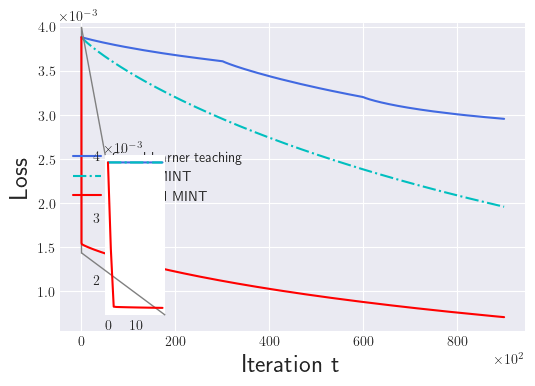

In [68]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
ax = sf.add_subplot()
plt.plot(Singleloss_t,color='royalblue',label='Singel-learner teaching')
plt.plot(Vanillaloss_t,color='c',linestyle='-.',label='Vanilla MINT')
plt.plot(Advancedloss_t,color='red',label='Advanced MINT')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.ticklabel_format(style='sci', scilimits=(2,2), axis='x',useMathText=True)
plt.legend()
#plt.xlim(-0.5,600)
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)

#-----------------zoom
xlim_1, xlim_2 = 0, 20
ax_zoom = sf.add_axes([0.2, 0.15, 0.1, 0.4], facecolor='white')
plt.plot(np.arange(xlim_1, xlim_2,1),Singleloss_t[xlim_1:xlim_2],color='royalblue')
plt.plot(np.arange(xlim_1, xlim_2,1),Vanillaloss_t[xlim_1:xlim_2],color='c',linestyle='-.')
plt.plot(np.arange(xlim_1, xlim_2,1),Advancedloss_t[xlim_1:xlim_2],color='red')

mark_inset(ax, ax_zoom, loc1=4, loc2=2, fc="none", ec="0.5")

plt.ticklabel_format(style='sci', scilimits=(-5,-6), axis='y',useMathText=True)


plt.show()
#sf.savefig(save_path+'/Loss_90k.pdf',bbox_inches='tight')

# Piece Lion

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

In [5]:
import torch
import numpy as np

In [6]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
data_path = os.path.join(script_path,'data','Lion Grey.jpg')
save_path = os.path.join(script_path,'out','Real-world')

RGB


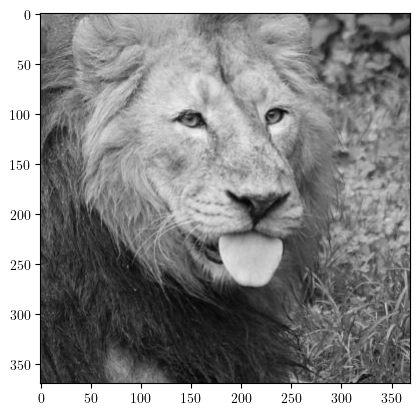

In [9]:
from PIL import Image
img = Image.open(data_path)
print(img.mode)
plt.imshow(img)

In [10]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

lion = 1 - transform(img)
print(torch.min(lion), torch.max(lion))
lion, _, _ = lion.unbind(0)

tensor(0.0314) tensor(0.9922)


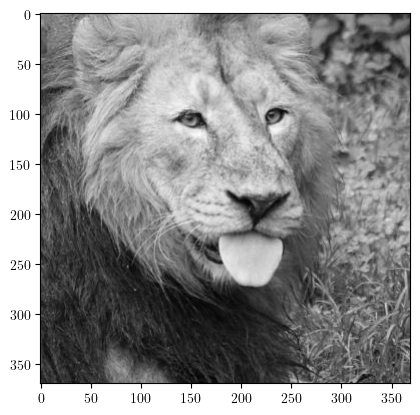

In [11]:
plt.imshow(lion,cmap='binary')

In [12]:
def piece1C(figure, parts):
    '''
    input is not a flatten vector
    '''
    H, W = figure.shape
    
    subH = int(H/parts)
    subW = int(W/parts)

    subFigure = torch.zeros(parts*parts, subH, subW)
    for i in range(parts):
        #split H firstly
        Hsp = figure[i*subH:(i+1)*subH,:]
        for j in range(parts):
            #split W secondly
            WHsp = Hsp[:,j*subW:(j+1)*subW]
            subFigure[i*parts + j] = WHsp
    return subFigure

In [13]:
def recoverPie1C(figure):
    '''
    input is not a flatten vector
    '''
    C, H, W = figure.shape
    
    parts = int(np.sqrt(C))
    
    rcvFigure = torch.zeros(parts*H, parts*W)
    for i in range(parts):
        for j in range(parts):
            rcvFigure[i*H:(i+1)*H,j*W:(j+1)*W] = figure[i*parts+j]
    return rcvFigure

In [14]:
parts = 4
pieLion = piece1C(lion, parts)

In [15]:
revLion = recoverPie1C(pieLion)

In [16]:
revLion.shape

torch.Size([368, 368])

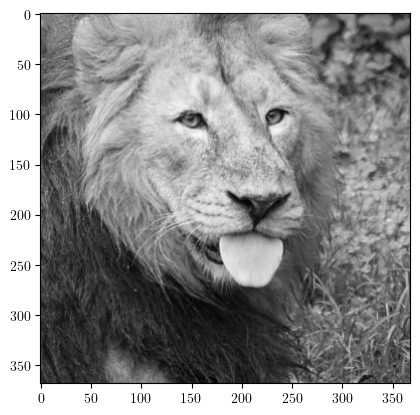

In [17]:
plt.imshow(revLion,cmap='binary')

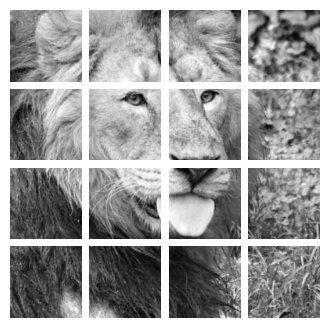

In [18]:
fig = plt.figure(figsize=(4,4))

grid = plt.GridSpec(parts, parts, wspace = .1, hspace = .1)

for i in range(parts*parts):
    exec(f"ax=fig.add_subplot(grid{[i]})")
    plt.imshow(pieLion[i],cmap='binary')
    ax.set_axis_off()

In [19]:
C, H, W = pieLion.shape
ini_pieLion = torch.zeros_like(pieLion)

In [20]:
comH, comW = lion.shape
ini_comLion = torch.zeros_like(lion)

## Vanilla

In [47]:
import time
eta = 0.01  # Learning rate.
num_iterations = 80000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

/home/zhangchen/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [48]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [49]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [50]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    '''
    Do not mean!!!! since all channel together
    '''
    #gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

Store necessary f_t

In [51]:
ite_list = [0, 5000, 10000, 30000, 50000, 80000]

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_pieLion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = pieLion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0.flatten()-y_star.flatten())/(parts*H*parts*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

f_tt = f_t[-1]

while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    sel_idx = greedy_1(f_tt.cuda(), y_star)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    
    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx] 
    
    '''
    intorduce replacement
    '''
    label = torch.zeros(len(sel_idx),1)
    f_x = torch.zeros(len(sel_idx),1)
    for i in range(len(sel_idx)):
        label[i] = y_star[i,sel_idx[i]]
        f_x[i] = f_tt[i,sel_idx[i]]

    '''label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]]])
    #print(label)
    
    f_x = torch.vstack([f_t[-1][0,sel_idx[0]],f_t[-1][1,sel_idx[1]]])
    #print(f_x)
    '''

    '''
    pixels are universal
    '''
    iter_count += 1
    
    
    f_tt = f_tt.cuda() -eta*gradient(example, f_x.cuda(), label.cuda(), pixels, rbf_kernel)
    if iter_count in ite_list:
        f_t.append(f_tt.cpu())
    
    l_t = torch.norm(f_tt.flatten().cuda()-y_star.flatten())/(parts*H*parts*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [54]:
torch.save([f_t, loss_t, tm_t],save_path+'/pieVanilla.pt')

Load data

In [55]:
f_t, loss_t, tm_t = torch.load(save_path+'/pieVanilla.pt')

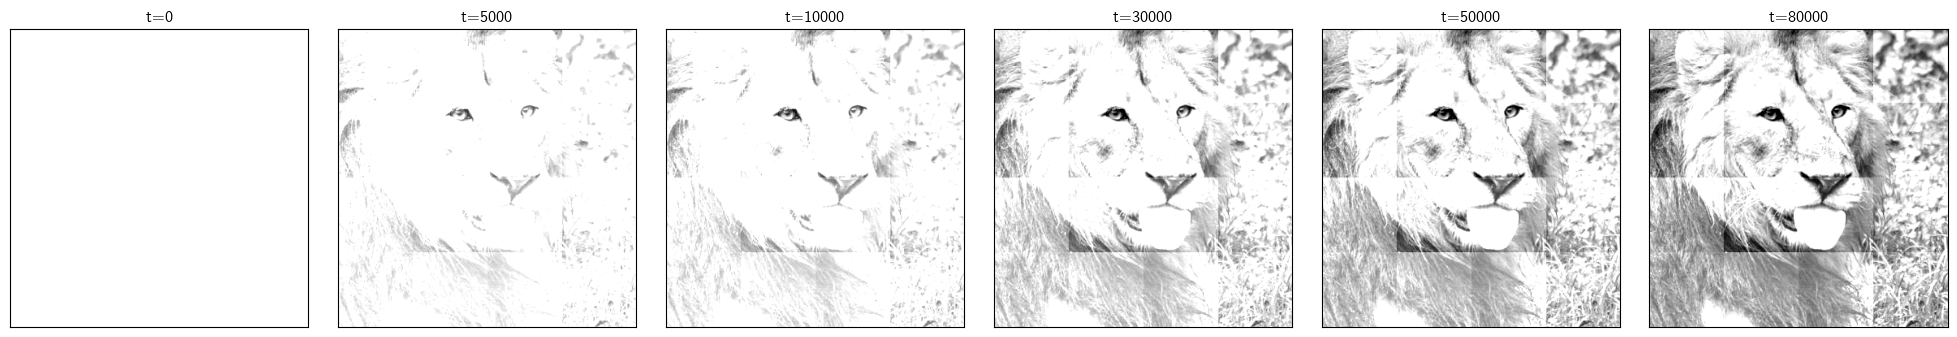

In [56]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=.5)

fig = plt.figure(figsize=(25,4))

ite_list = [0, 5000, 10000, 30000, 50000, 80000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise

    Z = f_t[mi].reshape(C, H, W) # alternative
    
    '''Combine'''
    im_Z = recoverPie1C(Z)
    
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm,cmap='binary')
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/pieVanilla.pdf'.format(1,2),bbox_inches='tight')

## Single

In [21]:
import time
eta = 0.01  # Learning rate.
num_iterations = 80000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, comH, 1)
x2 = torch.arange(0, comW, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

/home/zhangchen/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [23]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [24]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    '''
    Do not mean!!!! since all channel together
    '''
    gradient = gradient.squeeze(0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

Store necessary f_t

In [25]:
ite_list = [0, 5000, 10000, 30000, 50000, 80000]

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_comLion.flatten(start_dim=0).cuda()
f_t.append(y_0.cpu())
y_star = lion.flatten(start_dim=0).cuda()
loss_0 = torch.norm(y_0.flatten()-y_star.flatten())/(parts*H*parts*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

f_tt = f_t[-1]

while iter_count < num_iterations: #one error that 10 in Lenna.py
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    sel_idx = greedy_1(f_tt.cuda(), y_star)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    
    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx] 
    
    '''
    intorduce replacement
    '''
    label = y_star[sel_idx]
    f_x = f_tt[sel_idx]
    
    '''
    pixels are universal
    '''
    iter_count += 1
    
    
    f_tt = f_tt.cuda() -eta*gradient(example, f_x.cuda(), label.cuda(), pixels, rbf_kernel)
    if iter_count in ite_list:
        f_t.append(f_tt.cpu())
    
    l_t = torch.norm(f_tt.flatten().cuda()-y_star.flatten())/(parts*H*parts*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [28]:
torch.save([f_t, loss_t, tm_t],save_path+'/pieSingle.pt')

Load data

In [29]:
f_t, loss_t, tm_t = torch.load(save_path+'/pieSingle.pt')

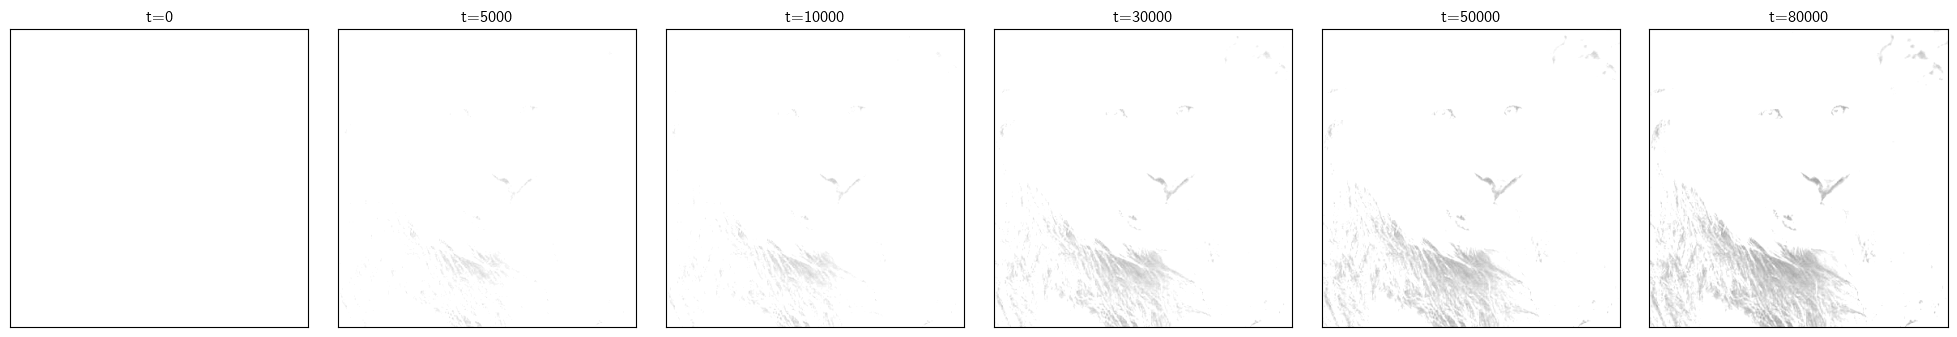

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=.5)

fig = plt.figure(figsize=(25,4))

ite_list = [0, 5000, 10000, 30000, 50000, 80000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise

    Z = f_t[mi].reshape(comH, comW) # alternative
    
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(Z,norm = norm,cmap='binary')
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/pieSingle.pdf'.format(1,2),bbox_inches='tight')

### Converge performance

In [31]:
_, Singleloss_t, _ = torch.load(save_path+'/pieSingle.pt')
_, Vanillaloss_t, _ = torch.load(save_path+'/pieVanilla.pt')

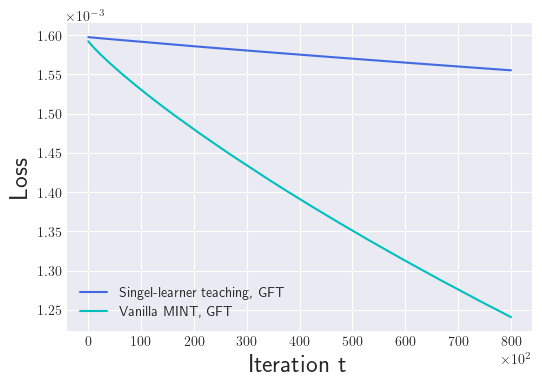

In [32]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
ax = sf.add_subplot()
plt.plot(Singleloss_t,color='royalblue',label='Singel-learner teaching, GFT')
plt.plot(Vanillaloss_t,color='c',label='Vanilla MINT, GFT')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.ticklabel_format(style='sci', scilimits=(2,2), axis='x',useMathText=True)
plt.legend(fontsize='10')
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)

plt.show()
sf.savefig(save_path+'/pieLoss.pdf',bbox_inches='tight')

# Multi animal

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

In [3]:
import torch
import numpy as np

In [4]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### scale

In [6]:
tig_path = os.path.join(script_path,'data','tiger.jpg')
che_path = os.path.join(script_path,'data','cheetah.jpg')
save_path = os.path.join(script_path,'out','Real-world')

In [7]:
min_side = 64

from PIL import Image
tig = Image.open(tig_path)
tig.thumbnail((min_side,min_side))
che = Image.open(che_path)
che.thumbnail((min_side,min_side))

In one channel, large value means dark, but in RGB, three large values bring bright. Thus need 1-

In [8]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

tig = 1 - transform(tig)
print(torch.min(tig), torch.max(tig))

che = 1 - transform(che)
print(torch.min(che), torch.max(che))

tensor(0.0275) tensor(1.)
tensor(0.) tensor(1.)


In [9]:
tig, _, _ = tig.unbind(0)
che, _, _ = che.unbind(0)

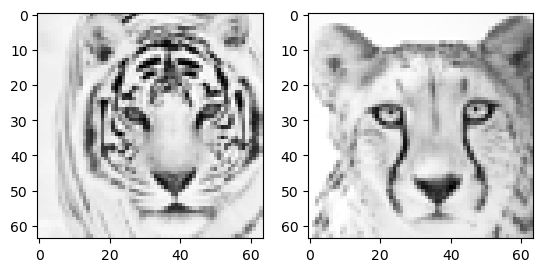

In [10]:
from PIL import Image
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(tig,cmap='binary')

ax = fig.add_subplot(1, 2, 2)
plt.imshow(che,cmap='binary')

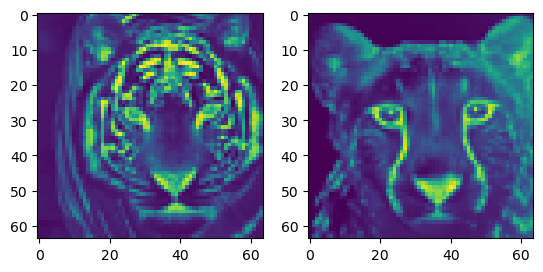

In [11]:
from PIL import Image
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(tig)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(che)

In [12]:
multask = torch.vstack([tig.unsqueeze(0),che.unsqueeze(0)])
C, H, W = multask.shape
ini_multask = torch.zeros_like(multask)

## Vanila

In [13]:
import time
eta = 0.01  # Learning rate.
num_iterations = 100000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

/home/zhangchen/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [15]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [16]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    print(torch.sum(gradient[0]-gradient[1]))
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    '''
    Do not mean!!!! since all channel together
    '''
    #gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_multask.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = multask.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    sel_idx = greedy_1(f_t[-1].cuda(), y_star)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    
    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx] 
    
    '''
    intorduce replacement
    '''
    
    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]]])
    
    f_x = torch.vstack([f_t[-1][0,sel_idx[0]],f_t[-1][1,sel_idx[1]]])
    
    '''
    pixels are universal
    '''
    f_tt = f_t[-1].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
    f_t.append(f_tt.cpu())
    
    l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [ ]:
a_f_t = []

ite_list = [0, 5000, 10000, 30000, 50000, 100000]

for i in ite_list:
    a_f_t.append(f_t[i])

In [ ]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/mulVanilla.pt')

Load data

In [17]:
save_path = os.path.join(script_path,'out','Real-world')

In [18]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/mulVanilla.pt')

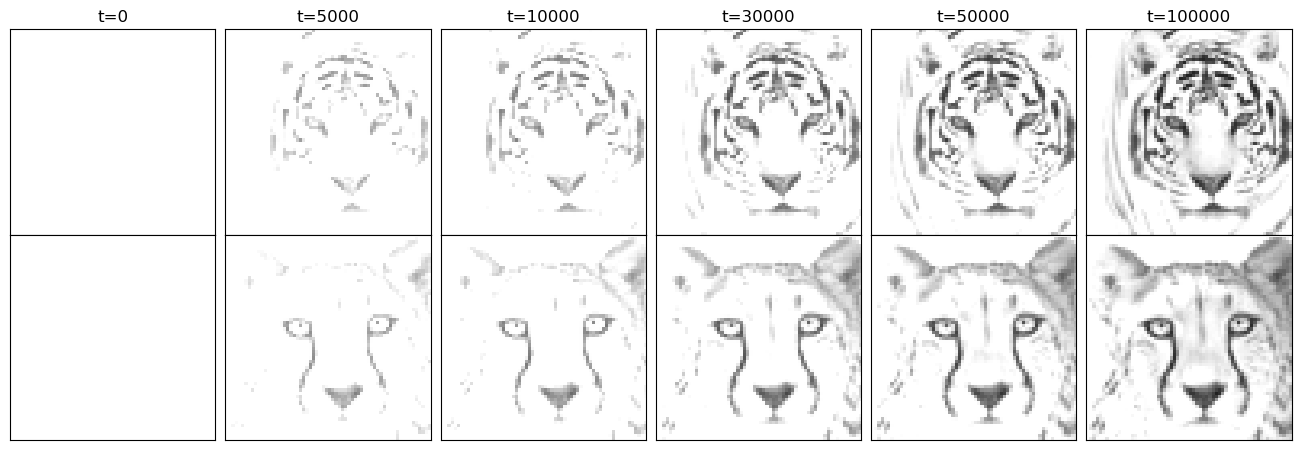

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib
plt.rcParams.update(plt.rcParamsDefault) 
rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.75, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,8))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list = [0, 5000, 10000, 30000, 50000, 100000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    tig, che = Z.unbind(0)
    
    cmb_Z = [tig, che]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm,cmap='binary')
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
#fig.savefig(save_path+'/mulVanilla.pdf'.format(1,2),bbox_inches='tight')

## Single

In [20]:
import time
eta = 0.01  # Learning rate.
num_iterations = 50000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [21]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [22]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [23]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    #gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_multask.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = multask.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

step = 0.05*num_iterations
for channel in range(C):
    iter_count = 0
    while iter_count < num_iterations:
        '''
        if np.remainder(iter_count, step) == 0:
            sel_idx = greedy_B(f_t[-1], y_star, 1)

        for random selection, generate sel_idx by random, random seed can be set as iter_count
        '''

        sel_idx = greedy_1(f_t[-1][channel].cuda(), y_star[channel])#, pool=True, plScale= 0.8
        '''
        np.random.seed(iter_count)
        sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
        '''

        '''
        example: [[x1,x2],[x1,x2]] int pixel point
        '''

        example = pixels[sel_idx]#torch.tensor([14,14])
        
        '''
        intorduce replacement
        '''
        label = y_star[channel][sel_idx] #f_star(example,channel)
        f_x = f_t[-1][channel][sel_idx]

        '''
        Need to clone otherwise previsous data will be changed as well
        '''
        temp = f_t[-1].detach().clone()
        temp[channel] = f_t[-1][channel].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
        
        f_t.append(temp.cpu())
        
        l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
        loss_t.append(l_t.item()) #norm over the cube
        tm_t.append(time.time() - training_start_time)
        iter_count += 1
        print('Channel: ',channel+1,' ',iter_count,'-th loss: ',loss_t[-1])
        print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [ ]:
a_f_t = []

ilist = [0, 5000, 10000, 20000, 30000, 50000]

for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        a_f_t.append(f_t[i][channel]) #[channel] here is important

In [ ]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/mulSingle.pt')

Load data

In [24]:
save_path = os.path.join(script_path,'out','Real-world')

In [25]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/mulSingle.pt')

separately show

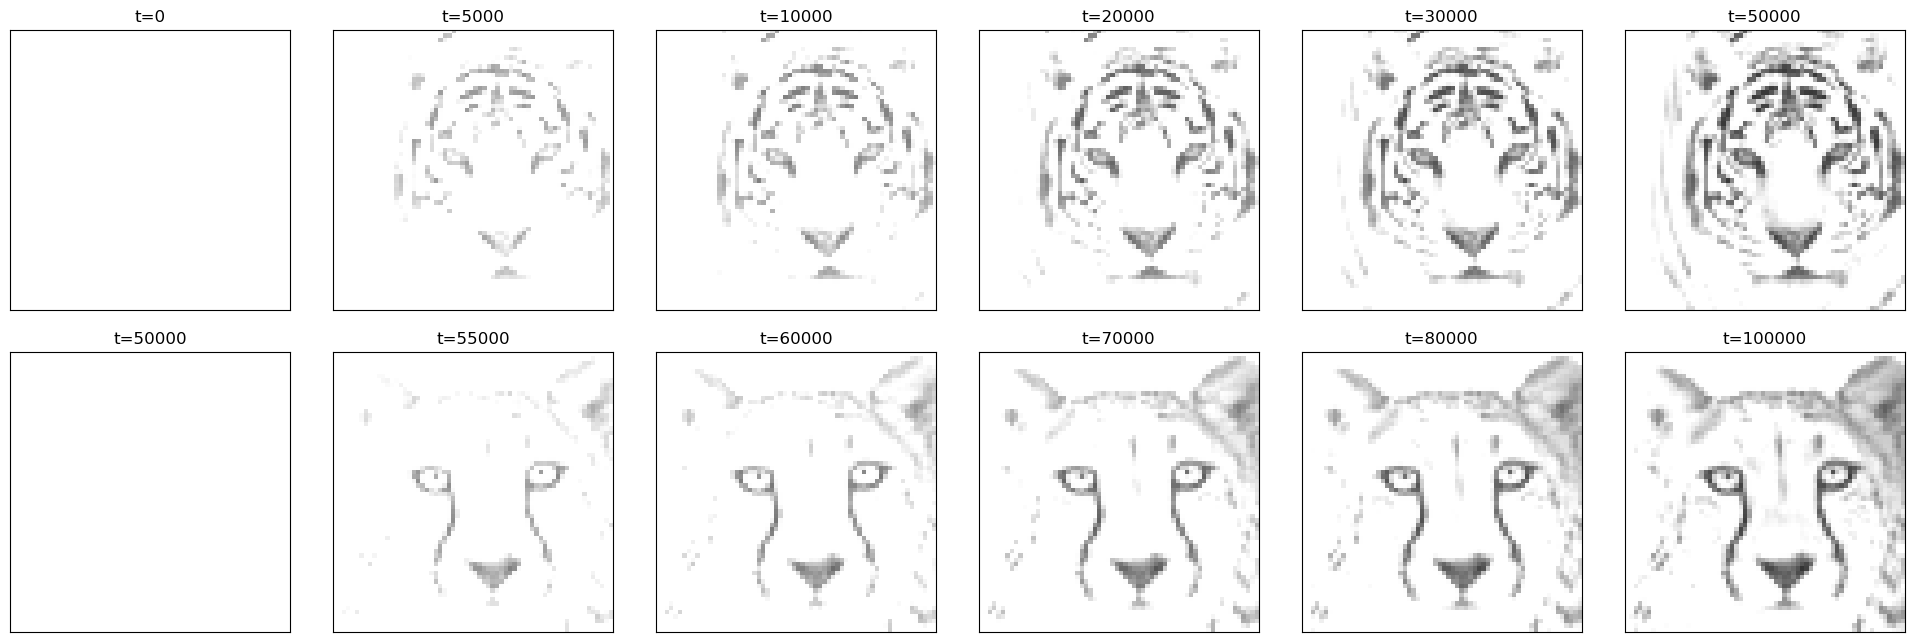

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = 0, hspace = .15)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ilist = [0, 5000, 10000, 20000, 30000, 50000] #[0,50,150,250,350, 550]


for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        j = ite_list.index(i)
        mi = j + channel*6 #omit otherwise
        
        #Z = f_t[i][channel].reshape(min_side,min_side) # alternative
        Z = a_f_t[mi].reshape(min_side,min_side)
        
        # Plot the surface.
        ax = fig.add_subplot(grid[channel,j])

        #surf = ax.contourf(X, -Y, Z, norm = norm, antialiased=False)

        ax.imshow(Z,norm = norm,cmap='binary')
        
        # Customize the z axis.
        #ax.set_zlim(-1.01, 1.01)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        #ax.zaxis.set_major_formatter('{x:.02f}')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_zticks([])
        # Add a color bar which maps values to colors.

        #ax.view_init(90,0)

        plt.title('t={}'.format(i))
    #fig.colorbar(surf, shrink=0.22, aspect=5)

plt.show()
#fig.savefig(save_path+'/mulSingle.pdf'.format(1,2),bbox_inches='tight')

show together

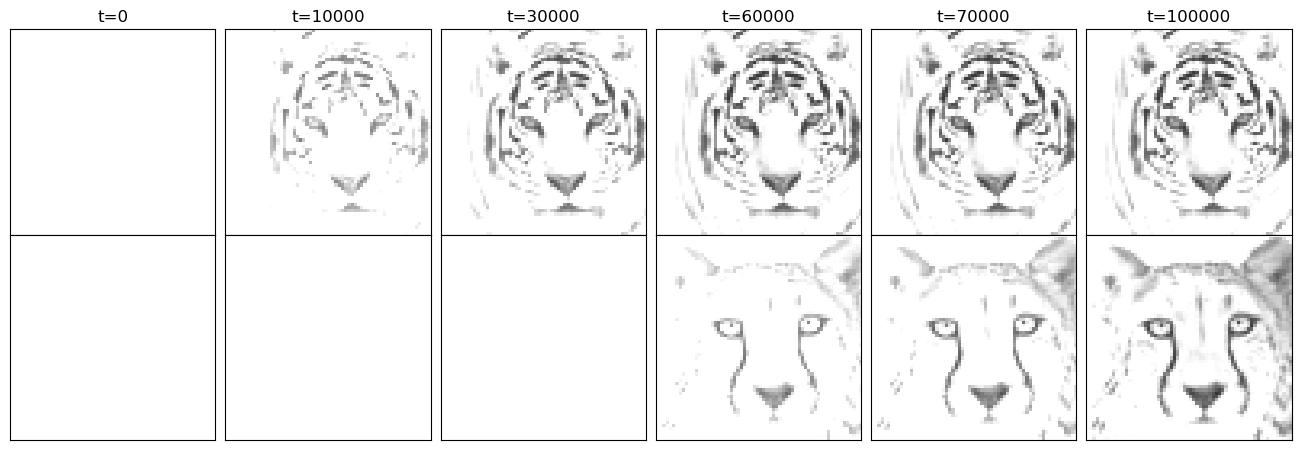

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib
plt.rcParams.update(plt.rcParamsDefault) 
rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.75, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,8))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

#a_f_t is [0, 5000, 10000, 20000, 30000, 50000, 50000, 55000, 60000, 70000, 80000, 100000]
ite_list = [0, 10000, 30000, 60000, 70000, 100000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    
    if i == 0:
        Z = a_f_t[mi].reshape(min_side,min_side)
        tig = Z
        che = a_f_t[6].reshape(min_side,min_side)
    elif i == 10000:
        Z = a_f_t[mi+1].reshape(min_side,min_side)
        tig = Z
        che = a_f_t[6].reshape(min_side,min_side)
    elif i == 30000:
        Z = a_f_t[mi+2].reshape(min_side,min_side)
        tig = Z
        che = a_f_t[6].reshape(min_side,min_side)
    elif i == 60000 or i == 70000:
        Z = a_f_t[mi+5].reshape(min_side,min_side)
        tig = a_f_t[5].reshape(min_side,min_side)
        che = Z
    else:
        Z = a_f_t[mi+6].reshape(min_side,min_side)
        tig = a_f_t[5].reshape(min_side,min_side)
        che = Z
        
    #tig, che = Z.unbind(0)
    
    cmb_Z = [tig, che]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm,cmap='binary')
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
#fig.savefig(save_path+'/mulSingle.pdf'.format(1,2),bbox_inches='tight')

## Converge performance

In [28]:
_, Singleloss_t, _ = torch.load(save_path+'/mulSingle.pt')
_, Vanillaloss_t, _ = torch.load(save_path+'/mulVanilla.pt')

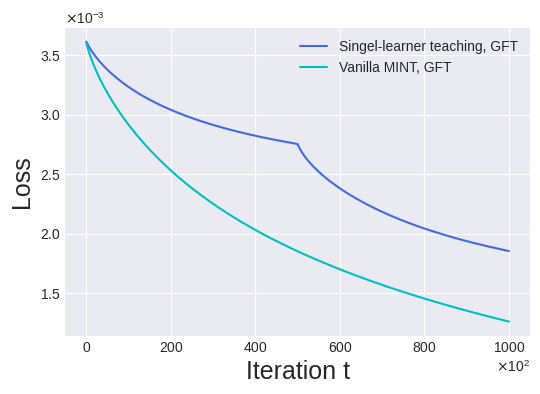

In [29]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
ax = sf.add_subplot()
plt.plot(Singleloss_t,color='royalblue',label='Singel-learner teaching, GFT')
plt.plot(Vanillaloss_t,color='c',label='Vanilla MINT, GFT')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.ticklabel_format(style='sci', scilimits=(2,2), axis='x',useMathText=True)
plt.legend(fontsize='10')
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)

plt.show()
#sf.savefig(save_path+'/mulLoss.pdf',bbox_inches='tight')